# Linear Regression


An ecommerce retailer is looking to use machine learning to understand its customer's online engagement with its digital outlets i.e website and app. It is trying to decide whether to focus its efforts on the mobile app experience or website. We will use Linear Regression model to see which user acitivity has the biggest impact on their likelyhood of spending more money.

#### Variables of interest:
Avg. Session Length: Average session of in-store style advice sessions.<br>
Time on App: Average time spent on App in minutes <br>
Time on Website: Average time spent on Website in minutes <br>
Length of Membership: How many years the customer has been a member <br>

In [1]:
# Snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import pandas_udf

# Pandas & json
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

### Set context

In [2]:
# Read credentials
with open('creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [3]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "RETAIL_TRANSACTIONS"
Schema                      : "PUBLIC"
Warehouse                   : "COMPUTE_WH"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 0.11.0


### Data Loading

In [4]:
customers = pd.read_csv("data.csv")
customers.head()

,EmailID,Customer Address,Avg. Session Length,Session Length on App,Session Length on Website,Duration of Subscription in Years,Yearly Expenditure
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",33.330673,12.795189,37.536653,4.446308,599.406092


In [7]:
# Create a Snowpark DF from the pandas DF
snowdf = session.createDataFrame(customers)

In [8]:
snowdf.show(2)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EmailID"                  |"Customer Address"          |"Avg. Session Length"  |"Session Length on App"  |"Session Length on Website"  |"Duration of Subscription in Years"  |"Yearly Expenditure"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mstephenson@fernandez.com  |835 Frank Tunnel            |34.49726773            |12.65565115              |39.57766802                  |4.082620633                          |587.951054            |
|                           |Wrightmouth, MI 82180-9605  |                       |                         |                             |                                     |                      |


In [9]:
# Loading customer data from Snowpark DF to a Snowflake internal table
snowdf.write.mode("overwrite").saveAsTable("customers_new") 
session.table("CUSTOMERS_NEW").limit(3).show(5)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EmailID"                  |"Customer Address"              |"Avg. Session Length"  |"Session Length on App"  |"Session Length on Website"  |"Duration of Subscription in Years"  |"Yearly Expenditure"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mstephenson@fernandez.com  |835 Frank Tunnel                |34.49726773            |12.65565115              |39.57766802                  |4.082620633                          |587.951054            |
|                           |Wrightmouth, MI 82180-9605      |                       |                         |                             |                                     |    

In [10]:
# Create a pandas data frame from the Snowflake table
custdf = session.table('CUSTOMERS_NEW').toPandas() 

print(f"'custdf' local dataframe created. Number of records: {len(custdf)} ")

'custdf' local dataframe created. Number of records: 500 


### Model Training & Testing

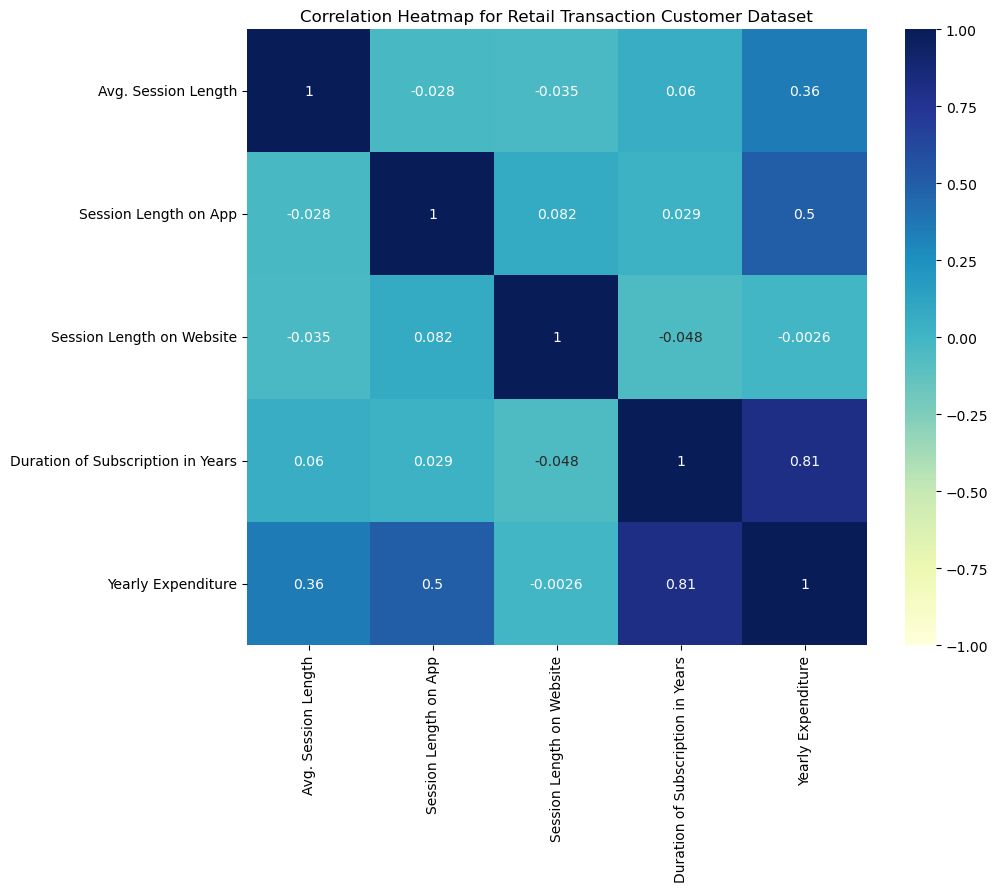

In [11]:
# Start by understanding the correlation matrix for the new data frame
f, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Correlation Heatmap for Retail Transaction Customer Dataset')
sns.heatmap(custdf.corr(), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')

In [12]:
# Define X and Y for modeling
X = custdf[['Avg. Session Length', 'Session Length on App', 'Session Length on Website', 'Duration of Subscription in Years']]
Y = custdf['Yearly Expenditure']

In [13]:
# Split into training & Testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                 test_size=0.3, random_state=101)

#### Linear Regression - Predict Yearly Spend

In [14]:
# Create an instance of Linear Regression and Fit the training datasets
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [15]:
# Creating a User Defined Function within Snowflake to do the scoring there
def predict_pandas_udf(df: pd.DataFrame) -> pd.Series:
    return pd.Series(lm.predict(df))  

In [17]:
# Creating UDF with above function
linear_model_vec = pandas_udf(func=predict_pandas_udf,
                                return_type = FloatType(),
                                input_types = [FloatType(), FloatType(), FloatType(), FloatType()],
                                session = session,
                                packages = ("pandas", "scikit-learn"), max_batch_size = 200)

In [18]:
# Calling the UDF to do the scoring (pushing down to Snowflake)
output = session.table('CUSTOMERS_NEW').select(*list(X.columns),
                    linear_model_vec(list(X.columns)).alias('PREDICTED_SPEND'), 
                    (F.col('Yearly Expenditure')).alias('ACTUAL_SPEND')
                    )

output.show(5)

Passing arguments to a UDF with a list or tuple is deprecated. We still respect this invocation but please consider passing variable-length arguments without a list or tuple.


-------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Avg. Session Length"  |"Session Length on App"  |"Session Length on Website"  |"Duration of Subscription in Years"  |"PREDICTED_SPEND"   |"ACTUAL_SPEND"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|34.49726773            |12.65565115              |39.57766802                  |4.082620633                          |594.4583823824203   |587.951054      |
|31.92627203            |11.10946073              |37.26895887                  |2.664034182                          |380.62290951875025  |392.2049334     |
|33.00091476            |11.33027806              |37.11059744                  |4.104543202                          |505.30810731557835  |487.5475049     |
|34.30555663            |13.71751367              |3

In [19]:
# Save the predicted output as a table on Snowflake
### used later in Streamlit app
output.write.mode("overwrite").saveAsTable("PREDICTED_CUSTOMER_SPEND") 

# Also get a local dataframe to review the results
output=output.toPandas()

##### Plotting and comparing the predicted values with actual spend values

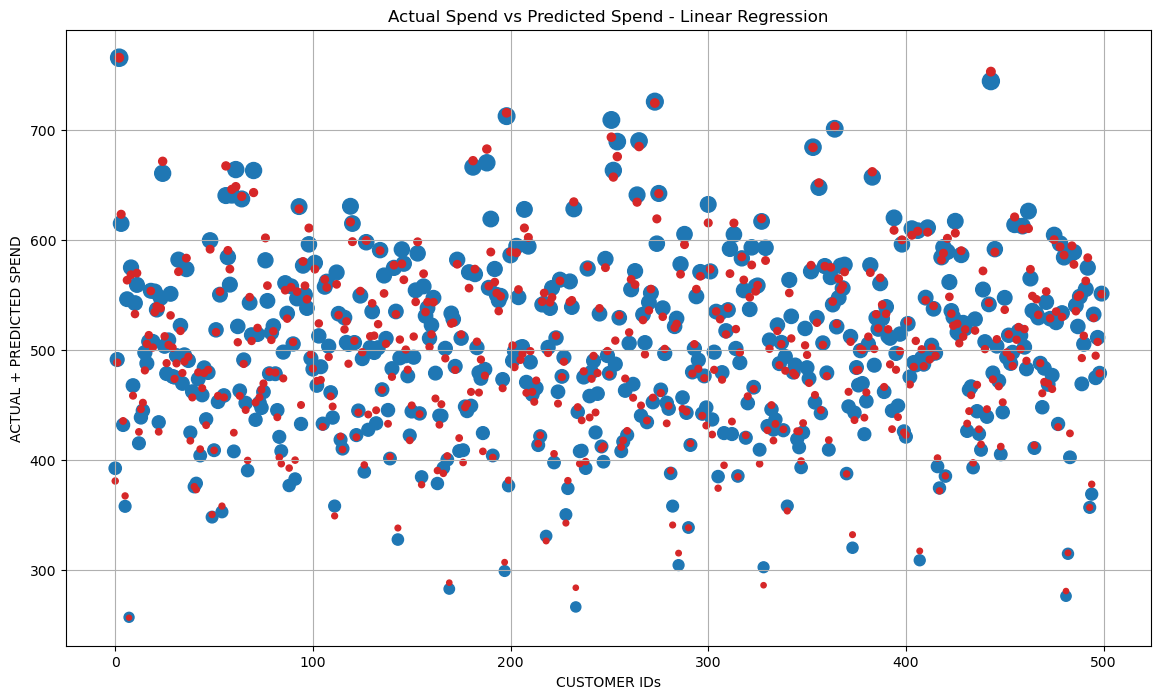

In [20]:
# Plot a descriptive scatter of predicted and actual values
x = output.index
y1 = output["ACTUAL_SPEND"]
y2 = output["PREDICTED_SPEND"]

f, ax = plt.subplots(figsize=(14, 8))
plt.scatter(x, y1, c='tab:blue', s=y1/5)
plt.scatter(x, y2, c='tab:red', s=y2/20)

plt.title(f"Actual Spend vs Predicted Spend - Linear Regression")
plt.ylabel("ACTUAL + PREDICTED SPEND")
plt.xlabel("CUSTOMER IDs")
ax.grid(True)
plt.show()

*To start with, define a function for regression metrics*

1. R² measures how much variability in dependent variable can be "explained by the model.
2. While R² is a relative measure of how well the model fits dependent variables, Mean Square Error is an absolute measure of the goodness for the fit.
3. Mean Absolute Error(MAE) is similar to MSE, however, unlike MSE, MAE takes the sum of the ABSOLUTE value of error.

*[Regression Merics Reference](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914)*

In [21]:
#1 & 2 Coefficient of Determination (R² & Adjusted R²)
print("\n--- Coefficient of Determination (R²) ---")
r2 = metrics.r2_score(y_pred=y2, y_true=y1)
print(f"R²: {round(r2, 2)}")

#3 & 4. MSE and RMSE
print("\n--- Mean Squared Error (MSE & RMSE) ---")

mse = metrics.mean_squared_error(y_pred=y2, y_true=y1, squared=True)
rmse = metrics.mean_squared_error(y_pred=y2, y_true=y1, squared=False)

print(f"MSE: {round(mse, 2)}")
print(f"RMSE: {round(rmse, 2)}")

#5. MAE
print("\n--- Mean Absolute Error (MAE) ---")
mae = metrics.mean_absolute_error(y_pred=y2, y_true=y1)
print(f"MAE: {round(mae, 2)}")


--- Coefficient of Determination (R²) ---
R²: 0.98

--- Mean Squared Error (MSE & RMSE) ---
MSE: 98.74
RMSE: 9.94

--- Mean Absolute Error (MAE) ---
MAE: 7.9


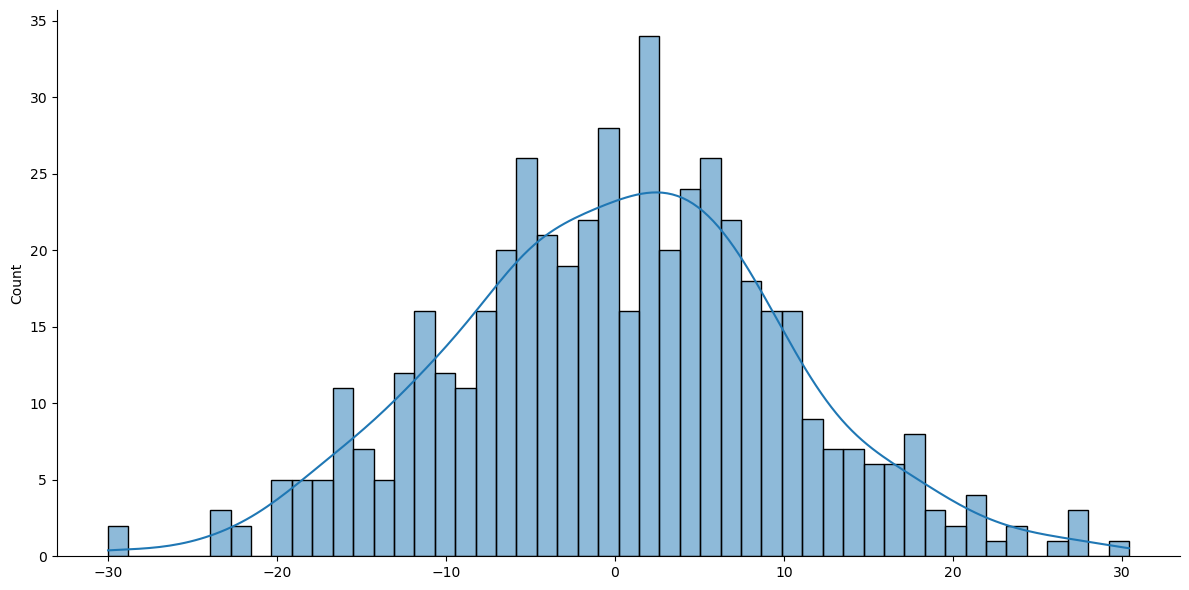

In [22]:
# Distribution of differences between actual and predicted values
# Gaussian kernel density estimate.

sns.displot((y2-y1),bins=50, kde=True, legend=True, height=6, aspect=2);

In [23]:
# Get coefficients from the fitted model
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient']).round(2)
coeff_df

,Coefficient
Avg. Session Length,25.98
Session Length on App,38.59
Session Length on Website,0.19
Duration of Subscription in Years,61.28


### Conclusion
**Session Length on App** and **Duration of Subscription in Years** are most important factors driving customer spend. The retailer should focus its efforts on increasing stickiness to its app and enhance its loyalty programs.